In [111]:
from os import listdir
import xmltodict
import pandas
from StringIO import StringIO
%matplotlib inline
from tqdm import tqdm
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from praelexis_file_system_provider.data_access_layer import AzureBlobStorageDataAccessLayer
import PyPDF2
import subprocess
import shutil
import os
try:
    import Image
except ImportError:
    from PIL import Image
import pytesseract
import cv2

Functions used to deskew the images

In [112]:
def orientationScore(image,skipStep = 10):
    totValue = 0
    for row in range(len(image)):
        rowVal = 0
        for col in range(0,len(image[0]),skipStep):
            rowVal += image[row][col]
        totValue += rowVal*rowVal
    return totValue

def findOrient(image,angleRange = 5,skipStep = 10):
    maxValue = -1
    maxRot  = 0
    imageRows, imageCols = image.shape
    accuracy = 0.1


    
    maxLen = angleRange*2*int(1/accuracy)
    #print maxLen
    for i in range(-1, maxLen):
        #rot = i
        rot = (round(i / 2 - 0.4) + 1) * ((-1) * (i % 2) + ((i + 1) % 2)) * 0.1
        #print rot
        # print("Rotation: ",rot,". i: ",i)
        M = cv2.getRotationMatrix2D((imageCols / 2, imageRows / 2), rot, 1)
        dst = cv2.warpAffine(image, M, (imageCols, imageRows), borderValue=(255, 255, 255))

        value = orientationScore(255-dst,skipStep = 10)
        if value>maxValue:
            maxValue = value
            maxRot = rot
        if int(maxLen/10)!=0 and i%int(maxLen/10)==0:
            print "Percentage complete: ", round(i*100.0/maxLen),"%. Current angle (degree): ",rot
        #print "Current angle: ",rot,". Current value: ", value,". Max value: ",maxValue,". Max rot: ",maxRot
        #cv2.imshow("Rotated Image: ",dst)
        #cv2.waitKey(0)

    M = cv2.getRotationMatrix2D((imageCols / 2, imageRows / 2), maxRot, 1)
    dst = cv2.warpAffine(image, M, (imageCols, imageRows), borderValue=(255, 255, 255))
    print "The best angle found at: ",maxRot
    #cv2.imshow("Rotated Image: ", dst)
    #cv2.waitKey(0)
    return dst

In [113]:
blob_dal = AzureBlobStorageDataAccessLayer('devcapitecdata', 'Gt5z0EAAAm5ZETk//WBnRiQUZ9FDB/BmLmbx5ZPRtDwh6vxTDAB/XzLlM+m/epfnDYcZ8JDfMEGg1p9tBW0iFQ==', 'bank-statements', home_directory='drop/Documentum_line_files')

In [114]:
blob_dal.connect()
files = blob_dal.list(path='CI')

In [115]:
f = files[0]
f_name = f.directory + f.name
print f_name

CI/0002a61d-054f-48af-a1da-e67f654cd074.pdf


In [116]:
stream = StringIO()
blob_dal.get(f_name, stream)
with open ("temp.pdf", 'w') as tmp:
  stream.seek (0)
  shutil.copyfileobj (stream, tmp)

In [117]:
subprocess.call(["convert","-density", "150", "temp.pdf","tmp.png"])

0

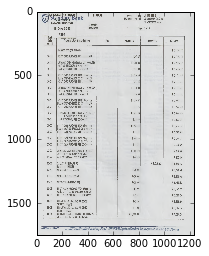

In [118]:
im = plt.imread('tmp-1.png')
#plt.figure(fig_size=(10,10))
plt.imshow(im)
plt.show()

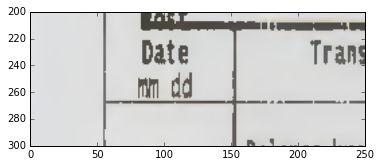

In [119]:
plt.imshow(im)
plt.axis([0,250,300,200])
plt.show()

Arguments for processing the image

In [120]:
args = {}
#args["image"] = "/home/dries/devel/Praelexis/OCR/Images/rotate.png"
#args["image"] = "/home/dries/devel/Praelexis/OCR/Images/rotatedDistorted.png"
#args["image"] = "/home/dries/devel/Praelexis/OCR/Images/RealScan.jpg"
#args["image"] = "/home/dries/devel/Praelexis/OCR/Images/phonePhoto.jpg"
#args["image"] = "/home/dries/devel/Praelexis/OCR/Images/bankRotatedBackround.jpg"
args["image"] = 'experimental/tmp_sharp-0.jpg'
args["output"] = 'OCROutput/'

args["preprocess"] = ""
args["rotationSearch"] = 2
con ="-psm 1 --oem 2 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLNMOPQRSTUVWXYZ-+,.()&:_/\*"
lan = "eng"

#print(pytesseract.image_to_string(Image.open('tmp-0.jpg'), lang='eng'))


Read and deskew image

In [121]:
# load the example image and convert it to grayscale
image = cv2.imread(args["image"])

# cv2.imshow("Image", image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite(args["output"] + 'Original.png',gray)
print("Finding orientation..")
gray = findOrient(gray,angleRange = args["rotationSearch"],skipStep = 10)
print("Image corrected.")

Finding orientation..
Percentage complete:  0.0 %. Current angle (degree):  0.1
Percentage complete:  10.0 %. Current angle (degree):  0.3
Percentage complete:  20.0 %. Current angle (degree):  0.5
Percentage complete:  30.0 %. Current angle (degree):  0.7
Percentage complete:  40.0 %. Current angle (degree):  0.9
Percentage complete:  50.0 %. Current angle (degree):  1.1
Percentage complete:  60.0 %. Current angle (degree):  1.3
Percentage complete:  70.0 %. Current angle (degree):  1.5
Percentage complete:  80.0 %. Current angle (degree):  1.7
Percentage complete:  90.0 %. Current angle (degree):  1.9
The best angle found at:  -0.0
Image corrected.


Generate text form the image using tesseract

In [122]:
print("Sending image through Tesseract..")
# check to see if we should apply thresholding to preprocess the
# image
if args["preprocess"] == "thresh":
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# make a check to see if median blurring should be done to remove
# noise
elif args["preprocess"] == "blur":
    gray = cv2.medianBlur(gray, 1)

'''cv2.namedWindow('Input', cv2.WINDOW_NORMAL)
cv2.imshow("Input", gray)    
cv2.waitKey(0)'''



# write the grayscale image to disk as a temporary file so we can
# apply OCR to it
#filename = "{}.png".format(os.getpid())
#cv2.imwrite(filename, gray)

# load the image as a PIL/Pillow image, apply OCR, and then delete
# the temporary file
#text = pytesseract.image_to_string(gray,boxes=False)


# This might not be the best approach. I think the system also directly searches for words.
# These word phrases are not included in the config settings.

cv2.imwrite(args["output"] + 'preProcessed.png',gray)

text = pytesseract.image_to_string(gray,lang=lan,boxes=False,config=con)

f = open(args["output"] + 'outputText.txt','w')
f.write(text)
f.close()
print "Text: ",text


Sending image through Tesseract..
Text:  ACCESSACC A:count number 10 052 577 390
Q Standard Bank Statement period 18 December 2017 to
26 September 2017
S3tltonthst r d
a can Account pre erre centre
STANDARD BANK Customer Contact Centre 0860 101 341
POLOKWANE Ac:ount manager
SQUARE BRANCH TeTephon1e
e-mai
1:3 Dec 2017 Internet mm.standardbank.co.za
7182 Page 1of 8
Date 18 December 2017
Time 08:06:22
Address : HARD 20 705 TSHAMAHANSINVILLAG
Account identification 9 MOKOPANE
A Name of account: NR FA*KHUTNANE 0600
Account number: 10 052 577 390
Transaction detaiis .
T Post ..
Md: Transaction description Fee Payments Deposits Baiance
rm -
Statement opening baiances R 3.36
09-26 FEE- POS DECLINED INSUFF FUNDS 07H34 R-7.90 R-4.54
payD MTN Eazi Recharge Jo
09-29 SALARY RUVIC SALARY R 7,616.26 R 7,611.72
09-29 NAEOO REPRESENTATION 0L0 R-80.56 R 7,531.16
MUTUAL667P039288626 170926
09-29 FEE - DEBIT ORDER R-9.50 R 7,521.66
09-29 BOL NAEOO REPRESENTATION SBSA LOAN R-1,877.77 R 5,643.89
10086408915

In [123]:
data = pytesseract.image_to_string(gray,boxes=True,config=con)
lines = data.split('\n')

array = []


yLen = len(gray)
newPage = gray.copy()

for i in range(len(newPage)):
    for j in range(len(newPage[0])):
        newPage[i][j] = 255

for line in lines:
    entry = line.split(' ')
    #print(entry)
    array.append(entry)
    cv2.rectangle(gray, (int(entry[1]), yLen-int(entry[2])), (int(entry[3]), yLen-int(entry[4])), (0,0,0), 1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    #print("Here: ",entry[0], " ", len(entry[0]))
    try:
        char = str(entry[0])
        #print(char)
        
        xSize = 0.5*(int(entry[3])-int(entry[1]))
        ySize = 0.5*(int(entry[4])-int(entry[2]))
        
        size = xSize
        
        if ySize>xSize:
            size = ySize
        
        fondSize = size/15.0
        loc = (int(entry[1])+int(0.5*(int(entry[3])-int(entry[1]))),yLen-int(entry[2])+int(0.5*(int(entry[4])-int(entry[2]))))
        cv2.putText(newPage,char,loc,font, fondSize,(0,0,255))
        #print char," ",fondSize, " ", loc
    except (TypeError, ValueError):
        print "Not added: ",entry
        xSize = 0.5*(int(entry[3])-int(entry[1]))
        ySize = 0.5*(int(entry[4])-int(entry[2]))
        
        size = xSize
        
        if ySize>xSize:
            size = ySize
        
        fondSize = size/15.0
        loc = (int(entry[1])+int(0.5*(int(entry[3])-int(entry[1]))),yLen-int(entry[2])+int(0.5*(int(entry[4])-int(entry[2]))))
        cv2.putText(newPage,'???',loc,font, fondSize,(0,0,255))
        
        
#data = pytesseract.image_to_boxes(gray)
#os.remove(filename)
#print "Text found:\n",text

#print "Data:\n",array
# show the output images

#for entry in data:
    #print "Entry: ", entry
    #cv2.rectangle(gray, (100, 100), (1000, 1000), (0,0,0), 20)
#cv2.namedWindow('Input', cv2.WINDOW_NORMAL)
#cv2.imshow("Input", gray)
cv2.imwrite(args["output"]+'Boxes.png',gray)
cv2.imwrite(args["output"]+'Estimation.png',newPage)
print "Process done. Go to output to view results."

Process done. Go to output to view results.
